In [1]:
import pandas as pd
from matplotlib import rc
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from numpy import array
import seaborn as sns

2022-10-20 04:55:33.555457: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-20 04:55:33.555480: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

In [3]:
df_colheitas= pd.read_csv('../colheitas/predictors/colheitas.csv', parse_dates=['date'])
df_colheitas['nr'].fillna(value=0, inplace=True)
df_colheitas=df_colheitas.groupby('date').sum()
df_colheitas=df_colheitas.resample(rule='MS').sum()
df_colheitas['type'] = 'supply'

In [4]:
df_consumos= pd.read_csv('../consumos/predictors/consumos.csv', parse_dates=['date'])
df_consumos['nr'].fillna(value=0, inplace=True)
df_consumos=df_consumos.groupby('date').sum()
df_consumos=df_consumos.resample(rule='MS').sum()
df_consumos['type'] = 'demand'

In [5]:
df = pd.concat([df_colheitas, df_consumos])
df = df.pivot_table('nr', 'date', 'type')

In [6]:
df['diff'] = df['supply'] - df['demand']

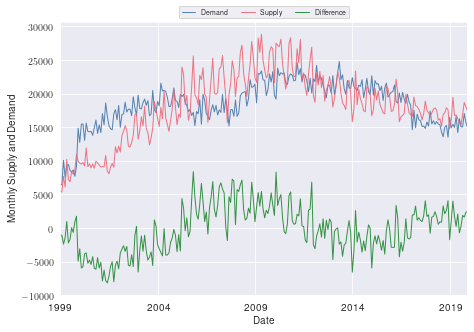

In [7]:
df.plot(figsize=(17*cm,12*cm), linewidth=1, alpha=0.9, color=[colors[0], colors[1], colors[2]], xlabel='Date', ylabel='Monthly Supply and Demand')
plt.legend(['Demand', 'Supply', 'Difference'],title_fontsize='small', fontsize='x-small', title='', loc="lower center", bbox_to_anchor=(0.5,1), ncol=5)
plt.tight_layout()
plt.savefig('figures/supply_demand_diff_monthly.pdf', bbox_inches = "tight")

In [8]:
def split_sequence(sequence, sequence_total, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence_total[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit LSTM model 

In [9]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=50)
    model = Sequential()
    model.add(LSTM(units=70, activation='relu', input_shape=(n_steps_in, 1)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=500, callbacks=[callback])
    return model 

In [10]:
def train_predict(dataset, dataset_total, test, actual):
    n_steps_in, n_steps_out, slide = 6, 2, 1
    X, y = split_sequence(dataset, dataset_total, n_steps_in, n_steps_out, slide)
    
    # flatten input and output
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))
    
    #print(X[0], y[0], len(X[0]), len(y[0]))
    model = fit(X, y, n_input, n_output)      
    
    mae, rmse, smape, preds = list(), list(), list(), list()
    for i in range(0, len(test)-n_steps_in, n_steps_out):
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_input, 1))
        pred = model.predict(x_input).reshape(-1, 1)
        pred = scaler.inverse_transform(pred)
        
        preds.extend(pred.tolist()[0])
        preds.extend(pred.tolist()[1])
        mae_aux, rmse_aux, smape_aux = measure_error(actual, pred, n_steps_in, n_steps_out, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
        #print(x_input, current_pred)
    
    return mae, rmse, smape, preds

In [11]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [12]:
def measure_error(actual, pred, step_in, step_out, index):
    print(actual[index+step_in:index+step_in+step_out],pred,index+step_in,index+step_in+step_out)
    mae = mean_absolute_error(actual[index+step_in:index+step_in+step_out], pred)
    rmse = np.sqrt(mean_squared_error(actual[index+step_in:index+step_in+step_out], pred))
    smape = sMAPE(actual[index+step_in:index+step_in+step_out], pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

In [13]:
dataset = df[['supply','demand']].values
dataset = df[['supply','demand']].astype('float32')
dataset_diff = df[['diff']].values
dataset_diff = df[['diff']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset_diff = scaler.fit_transform(dataset_diff)
mae, rmse, smape, pred_diff = train_predict(dataset[:216], dataset_diff[:216], dataset[216:], df[['diff']][216:].values)

2022-10-20 04:55:36.347419: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-20 04:55:36.347452: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-20 04:55:36.347825: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
7/7 [==============================] - 1s 7ms/step - loss: 0.2137
Epoch 2/500
7/7 [==============================] - 0s 12ms/step - loss: 0.1239
Epoch 3/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0509
Epoch 4/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0518
Epoch 5/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0385
Epoch 6/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0431
Epoch 7/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0401
Epoch 8/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0388
Epoch 9/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0387
Epoch 10/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0391
Epoch 11/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0386
Epoch 12/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0389
Epoch 13/500
7/7 [==============================] - 0s 7ms/

7/7 [==============================] - 0s 8ms/step - loss: 0.0234
Epoch 105/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0231
Epoch 106/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0247
Epoch 107/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0229
Epoch 108/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0217
Epoch 109/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0214
Epoch 110/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0215
Epoch 111/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0222
Epoch 112/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0224
Epoch 113/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0215
Epoch 114/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0235
Epoch 115/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0232
Epoch 116/500
7/7 [==============================] - 

7/7 [==============================] - 0s 8ms/step - loss: 0.0191
Epoch 207/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0196
Epoch 208/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0198
Epoch 209/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0197
Epoch 210/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0200
Epoch 211/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0191
Epoch 212/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0216
Epoch 213/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0191
Epoch 214/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0203
Epoch 215/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0236
Epoch 216/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0212
Epoch 217/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0197
Epoch 218/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 13ms/step - loss: 0.0196
Epoch 309/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0206
Epoch 310/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0177
Epoch 311/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0186
Epoch 312/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0175
Epoch 313/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0176
Epoch 314/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0186
Epoch 315/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0175
Epoch 316/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0174
Epoch 317/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0171
Epoch 318/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0176
Epoch 319/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0174
Epoch 320/500
7/7 [==============================

7/7 [==============================] - 0s 8ms/step - loss: 0.0169
Epoch 411/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0166
Epoch 412/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0174
Epoch 413/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0170
Epoch 414/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0176
Epoch 415/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0176
Epoch 416/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0178
Epoch 417/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0171
Epoch 418/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0166
Epoch 419/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0166
Epoch 420/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0168
Epoch 421/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0162
Epoch 422/500
7/7 [==============================] - 0

In [14]:
df_pred = df[222:]
df_pred['pred_diff'] = pred_diff

/tmp/ipykernel_70317/554903396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['pred_diff'] = pred_diff


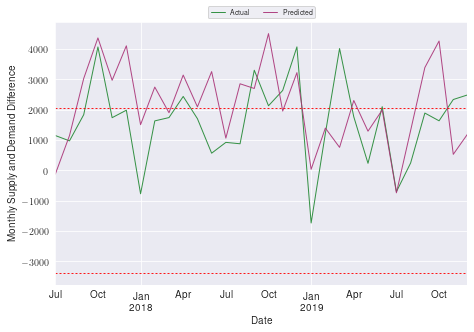

In [15]:
df_pred[['diff', 'pred_diff']].pivot_table(index="date").plot(figsize=(17*cm,12*cm), linewidth=1, alpha=0.9, color=[colors[2], colors[5]], xlabel='Date', ylabel='Monthly Supply and Demand Difference')
plt.legend(['Actual', 'Predicted'],title_fontsize='small', fontsize='x-small', title='', loc="lower center", bbox_to_anchor=(0.5,1), ncol=5)
q1 = np.quantile(df[['diff']][:216].values, 0.25)
q2 = np.quantile(df[['diff']][:216].values, 0.50)
q3 = np.quantile(df[['diff']][:216].values, 0.75)
plt.axhline(y=q1, color='r', dashes=(2,2), linewidth=1, alpha=0.9)
plt.axhline(y=q3, color='r', dashes=(2,2), linewidth=1, alpha=0.9)
plt.tight_layout()
plt.savefig('figures/supply_demand_diff_monthly_pred.pdf', bbox_inches = "tight")

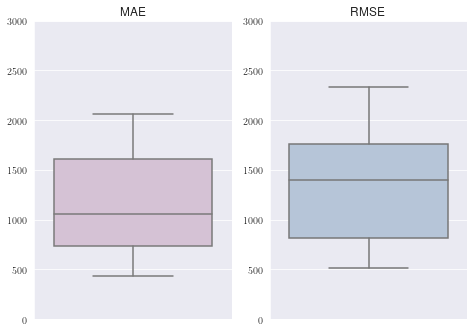

In [16]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 3000))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 3000))
plt.tight_layout()
plt.savefig('figures/supply_demand_diff_monthly_pred_boxplot.pdf', bbox_inches = "tight")

In [17]:
supply_demand_lstm_month_diff = [mae,rmse,smape]
%store supply_demand_lstm_month_diff

Stored 'supply_demand_lstm_month_diff' (list)
